## seasonal patterns of NLCT events

* 2023 Dec 22: fixed to only ingest NCLT data in netcdf form (previously would use picked xarray data)

In [1]:
import glob
import xarray as xr
import pickle
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np

In [2]:
region = "oaxaca"
nlct_path = "/mnt/data2/jturner/nlct_data/"+region+"/"
hour = "07"

Creating seasonal average for month: 

In [3]:
month = '01' #mm
month_name = 'Jan'

In [4]:
files = sorted(glob.glob(nlct_path+'202?'+month+'*/*'+hour+'H_00M.nc'))

In [5]:
for file in files: 
    print(file.split('/')[-2])

count = len(files)
print(count)

20220101
20220102
20220103
20220104
20220105
20220106
20220107
20220108
20220109
20220110
20220111
20220112
20220113
20220114
20220115
20220116
20220117
20220118
20220119
20220120
20220121
20220122
20220123
20220124
20220125
20220126
20220127
20220128
20220129
20220130
20220131
20230101
20230102
20230103
20230104
20230105
20230106
20230107
20230108
20230109
20230110
20230111
20230112
20230113
20230114
20230115
20230116
20230117
20230118
20230119
20230120
20230121
20230122
20230123
20230124
20230125
20230126
20230127
20230128
20230129
20230130
20230131
62


Each NLCT file is a saved xarray DataArray, they need the dictionary to be appended into a Dataset:

In [6]:
datasets = []

for file in files:
    ds = xr.open_dataset(file)
    ds['__xarray_dataarray_variable__'] = xr.where(ds['__xarray_dataarray_variable__'] < 0, 0, ds['__xarray_dataarray_variable__'])
    datasets.append(ds)
    
nlct_ds = xr.concat(datasets, dim='time')

In [7]:
#--- No cropping
# max_x = np.max(nlct_ds.x.values)
# min_x = np.min(nlct_ds.x.values)
# max_y = np.max(nlct_ds.y.values)
# min_y = np.min(nlct_ds.y.values)

#--- Oaxaca cropping adjustments
max_x = np.max(nlct_ds.x.values) -0.025 
min_x = np.min(nlct_ds.x.values) +0.025
max_y = np.max(nlct_ds.y.values) -0.005
min_y = np.min(nlct_ds.y.values) +0.005

x_range = slice(min_x, max_x)
y_range = slice(max_y, min_y)

nlct_ds_sm = nlct_ds.sel(x=x_range, y=y_range)

In [8]:
btd_tot = nlct_ds_sm['__xarray_dataarray_variable__'].sum(dim='time')
btd_mean = btd_tot/count

In [9]:
overall_mean = btd_mean.mean(dim='y')
overall_mean = overall_mean.mean(dim='x')

In [10]:
high_lim = overall_mean.values
low_lim = overall_mean.values

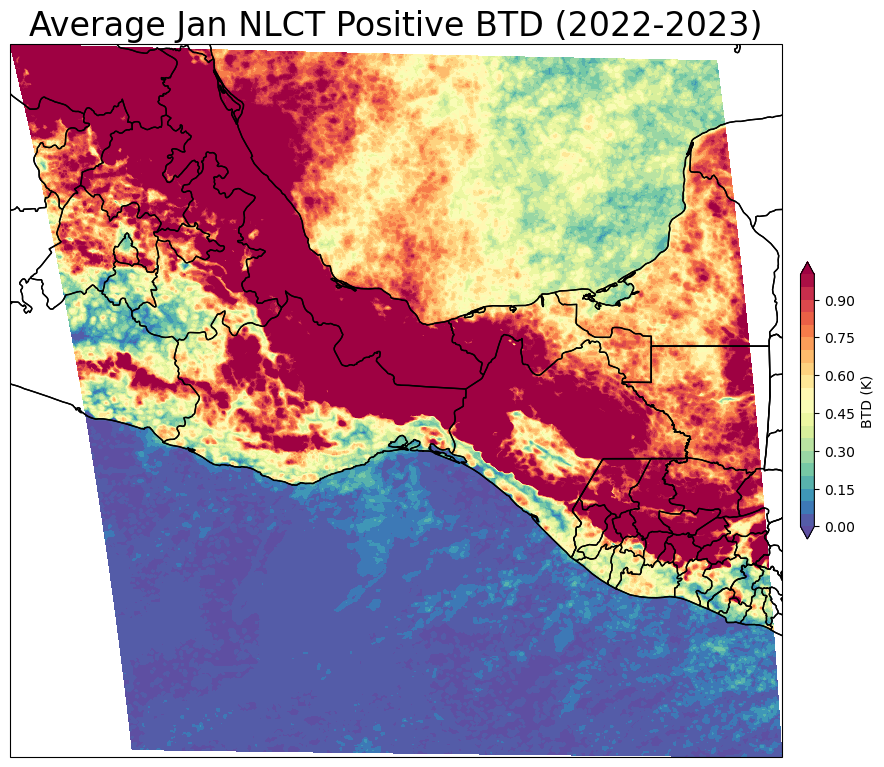

In [11]:
projection=ccrs.PlateCarree()
fig,ax=plt.subplots(1, figsize=(12,12),subplot_kw={'projection': projection})
cmap = plt.cm.Spectral_r
levels = np.linspace(0, 1, 21)

#--- Falklands needs set extent
# min_lon = -75
# min_lat = -58
# max_lon = -50
# max_lat = -35
# ax.set_extent([min_lon, max_lon, min_lat, max_lat])

c=ax.contourf(btd_mean.lon, btd_mean.lat, btd_mean, cmap=cmap, extend='both', levels=levels)
clb=plt.colorbar(c, shrink=0.3, pad=0.02, ax=ax)
ax.set_title('Average '+month_name+' NLCT Positive BTD (2022-2023)', fontsize=24)
clb.set_label('BTD (K)')

ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.COASTLINE)

#plt.savefig('NLCT_Seasonal/'+month_name+'_nclt.png', bbox_inches='tight')

### Running climatology for multiple months

In [12]:
def Calc_BTD_mean(month_id):
    
    #--- Create month number
    month_num = str(month_id+1).zfill(2)
    
    print(month_num)
    files = sorted(glob.glob(nlct_path+'202?'+month_num+'*/*'+hour+'H_00M.nc'))
    count = len(files)
    datasets = []

    for file in files:
        ds = xr.open_dataset(file)
        #--- Set negative values to zero
        ds['__xarray_dataarray_variable__'] = xr.where(ds['__xarray_dataarray_variable__'] < 0, 0, ds['__xarray_dataarray_variable__'])
        datasets.append(ds)

    nlct_ds = xr.concat(datasets, dim='time')
    nlct_ds_sm = nlct_ds.sel(x=x_range, y=y_range)
    btd_tot = nlct_ds_sm['__xarray_dataarray_variable__'].sum(dim='time')
    btd_mean = btd_tot/count
    
    return btd_mean

Throws an error if there is not data for each month

Settings for Gulf Stream: 
* num_rows = 6
* num_cols = 2
* figsize = (12, 16)

01
02
03
04
05
06
07
08
09
10
11
12


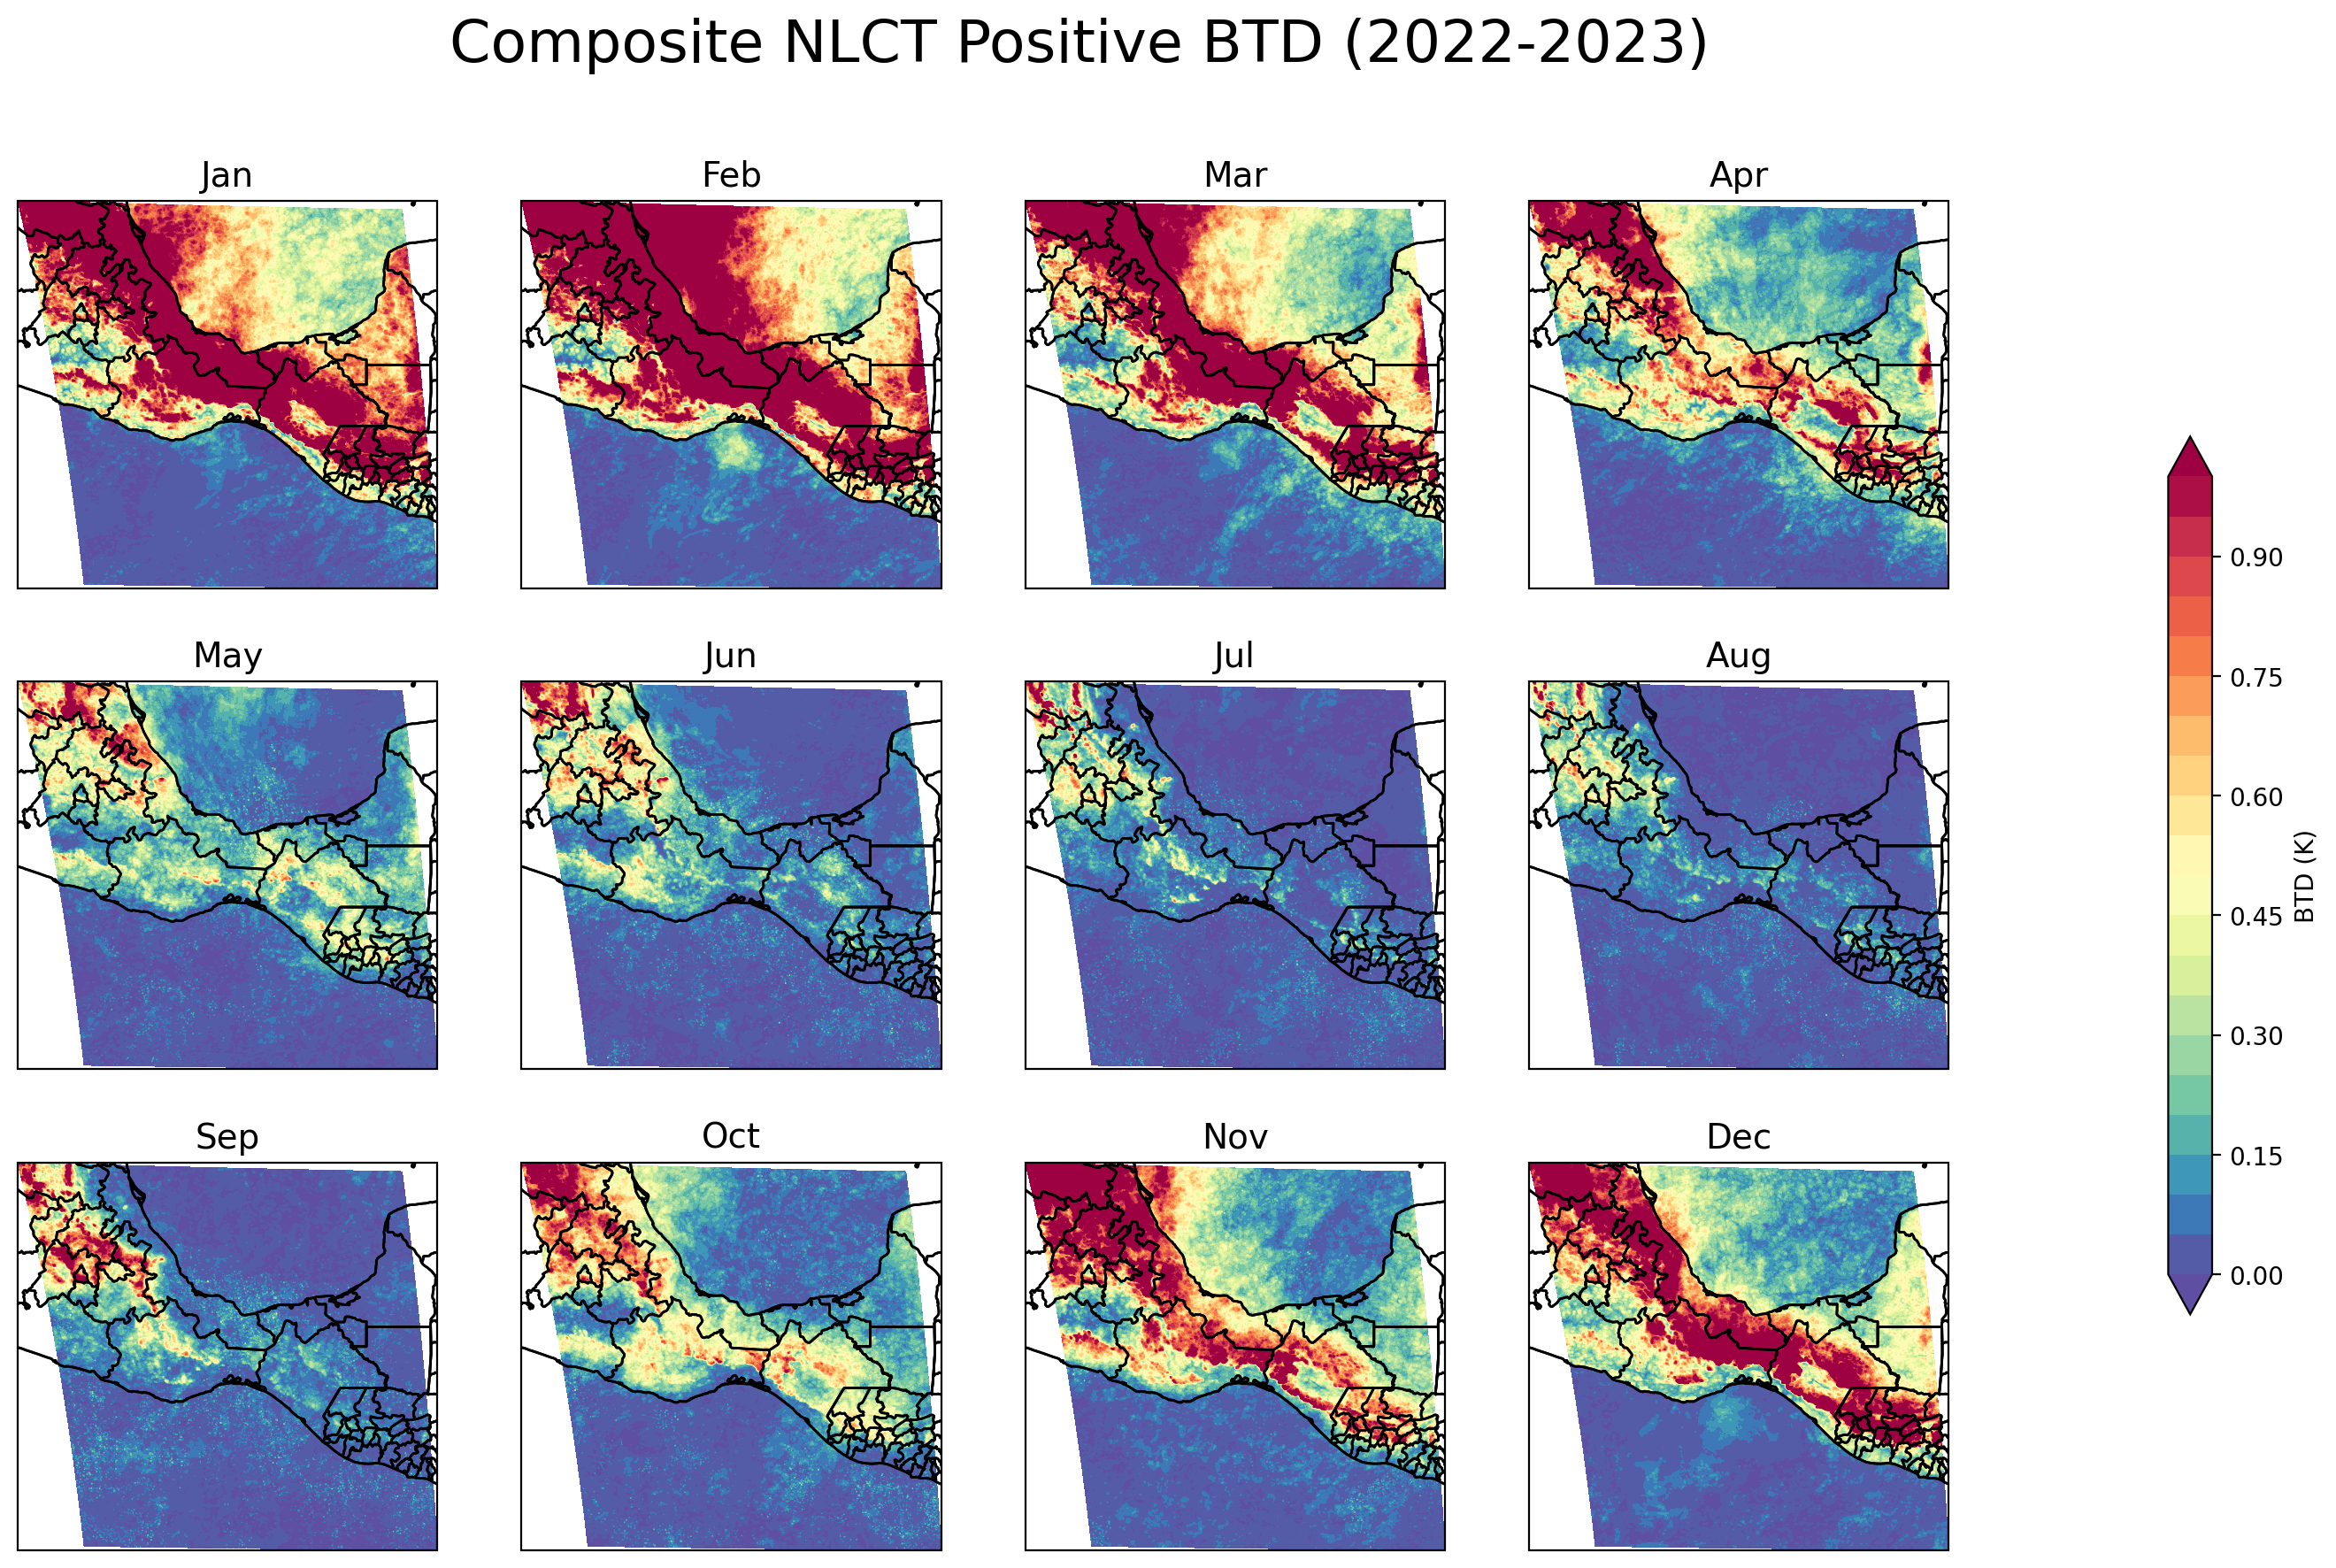

In [13]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

#--- Calculate the number of rows and columns for the subplots
num_months = len(months)
num_rows = int(num_months**0.5)
num_cols = (num_months + num_rows - 1) // num_rows

#--- Create a figure and an array of subplots
projection=ccrs.PlateCarree()
fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 10), subplot_kw={'projection': projection})
cmap = plt.cm.Spectral_r
levels = np.linspace(0, 1, 21)

#--- Flatten the 2D array of subplots to simplify indexing
axes = axes.flatten()

#--- Falklands needs set extent
# min_lon = -75
# min_lat = -58
# max_lon = -50
# max_lat = -35

for i, month in enumerate(months):
    #--- Falklands needs set extent
    #axes[i].set_extent([min_lon, max_lon, min_lat, max_lat])
    
    btd_mean = Calc_BTD_mean(i)
    c=axes[i].contourf(btd_mean.lon, btd_mean.lat, btd_mean, cmap=cmap, extend='both', levels=levels)
    axes[i].set_title(month, fontsize=14)
    axes[i].add_feature(cfeature.STATES)
    axes[i].add_feature(cfeature.BORDERS)
    axes[i].add_feature(cfeature.COASTLINE)

    
cbar = plt.colorbar(c, ax=axes, orientation='vertical', fraction=0.02, pad=0.1)
cbar.set_label('BTD (K)')  

    
fig.suptitle('Composite NLCT Positive BTD (2022-2023)', fontsize=24)
fig.set_dpi(200)
plt.savefig('nclt_seasonal_'+region+'.png', dpi=200, bbox_inches='tight')